In [103]:
import pandas as pd
from statistics import mean, stdev
import matplotlib.pyplot as plt
from os import listdir
from rlhfutils.eval_utils import scofile
from scipy.stats import pearsonr, spearmanr
import numpy as np
from datasets import Dataset

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
alldfs['dpobow25_rm80']

,question,response,answers,atoks,ttoks,scores,gold
0,Below is an instruction that describes a task....,[Question: can you make the following recipe v...,"[ If you would like this information, please c...","[50, 49, 50, 20]","[476, 475, 476, 446]","[10.625, 9.9921875, 12.3359375, -6.44140625]","[2, 3, 4, 1]"
1,Below is an instruction that describes a task....,[Question: Detailed Instructions: In this task...,[ I would like to thank you for your time and ...,"[50, 50, 50, 50]","[204, 204, 204, 204]","[11.0234375, 10.1015625, 3.7109375, 8.2578125]","[3, 4, 2, 2]"
2,Below is an instruction that describes a task....,"[Question: hi, iam going to provide you with a...",[ We are a small company trying to bring our s...,"[50, 50, 50, 50]","[131, 131, 131, 131]","[-3.951171875, 2.888671875, 10.984375, 6.734375]","[1, 3, 4, 2]"
3,Below is an instruction that describes a task....,[Question: How would I connect AI or ML API’s ...,[ If you have any queries about our data and d...,"[50, 50, 50, 50]","[97, 97, 97, 97]","[6.48046875, -0.802734375, 5.47265625, 13.484375]","[3, 2, 3, 6]"
4,Below is an instruction that describes a task....,[Question: 아래 책 내용 요약해줘 \n- 제목 : Don't Make Me...,"[ If you want to use this method, you need to ...","[50, 49, 50, 47]","[119, 118, 119, 116]","[10.59375, 11.140625, 2.578125, 4.0]","[5, 5, 2, 3]"
...,...,...,...,...,...,...,...
95,Below is an instruction that describes a task....,[Question: Is rubbish the most fragrant plant?...,[ I would like to discuss with you why this sh...,"[50, 50, 50, 50]","[64, 64, 64, 64]","[-0.1218261719, 12.203125, 2.23828125, 4.4609375]","[2, 5, 3, 3]"
96,Below is an instruction that describes a task....,[Question: i want you act as my python tutor a...,[ You must complete two of your following task...,"[50, 50, 49, 50]","[68, 68, 67, 68]","[6.69140625, 1.3828125, 2.234375, 1.525390625]","[4, 3, 2, 2]"
97,Below is an instruction that describes a task....,[Question: TASK DEFINITION: Given a sentence i...,[ If you have any questions regarding this com...,"[50, 50, 50, 50]","[401, 401, 401, 401]","[9.4453125, 6.74609375, 2.66015625, 9.8046875]","[4, 2, 1, 3]"
98,Below is an instruction that describes a task....,"[Question: Instructions: In this task, you are...",[ If you have no information about how we migh...,"[50, 50, 50, 50]","[129, 129, 129, 129]","[13.03125, 13.546875, 14.125, 8.875]","[5, 4, 7, 4]"


In [8]:
# TODO assert that the lengths work in the right way (limited to 50), otherwise these comparisons aren't useful anymore
# maybe also get a case for 25 to get stuff closer to the interesting range of what the RM can learn

In [105]:
def diffplot(scos, golds):
    sdiffs = []
    gdiffs = []
    for i in range(len(scos)):
        for j in range(i+1,len(scos)):
            if golds[i]>golds[j]:
                sdiffs.append(scos[i]-scos[j])
                gdiffs.append(golds[i]-golds[j])
            else:
                sdiffs.append(scos[j]-scos[i])
                gdiffs.append(golds[j]-golds[i])
    return sdiffs, gdiffs

# given alldfs, and a list of keys to merge, we're going to get n choose 2 pairs of indices, x will be score diff, y will be gold diff, then we'll measure the correlation (within each context)
def checkdistcorrs(adfs, selkeys, cfunct=pearsonr):
    # first merge all the scores across the adf keys (more diversity in scoring)
    scos = list(adfs[selkeys[0]]['scores'])
    golds = list(adfs[selkeys[0]]['gold'])
    for i in range(1, len(selkeys)):
        for j in range(len(scos)):
            scos[j] = scos[j]+adfs[selkeys[i]]['scores'].loc[j]
            #print(adfs[selkeys[i]]['scores'].loc[j])
            golds[j] = golds[j] + adfs[selkeys[i]]['gold'].loc[j]
    print(scos[0])
    sps = []
    gps = []
    corrs = []
    pvals = []
    # get the combination-based diff plots for all of these, then return that
    for i in range(len(scos)):
        sp, gp = diffplot(scos[i], golds[i])
        sps.append(sp)
        gps.append(gp)
        corrs.append(cfunct(gp, sp).statistic)
        pvals.append(cfunct(gp, sp).pvalue)
    print(np.nanmean(corrs))
    plt.hist(corrs)
    plt.scatter(corrs, pvals)
    return sps, gps

# for different gold values, what's the mean variance of RM scores for those
def unvar(slist, glist):
    uns = set(glist)
    gdict = {}
    for i in range(len(slist)): 
        gval = glist[i]
        if gval not in gdict.keys(): 
            gdict[gval] = []
        gdict[gval].append(slist[i])
    vdict = {g:(len(gdict[g]), stdev(gdict[g]) if len(gdict[g])>1 else 0) for g in gdict.keys()}
    mdict = {g:mean(gdict[g]) for g in gdict.keys()}
    return vdict, mdict

# forget about inputs, compute some info about the relationship between arbitrary pairs
def agginfo(adfs, selkeys):
    # first merge all the scores across the adf keys (more diversity in scoring)
    scos = list(adfs[selkeys[0]]['scores'])
    golds = list(adfs[selkeys[0]]['gold'])
    for i in range(1, len(selkeys)):
        for j in range(len(scos)):
            scos[j] = scos[j]+adfs[selkeys[i]]['scores'].loc[j]
            #print(adfs[selkeys[i]]['scores'].loc[j])
            golds[j] = golds[j] + adfs[selkeys[i]]['gold'].loc[j]
    ascos = []
    agolds = []
    for i in range(len(scos)):
        ascos.extend(scos[i])
        agolds.extend(golds[i])
    vard, md = unvar(ascos, agolds)
    print(vard)
    plt.errorbar(md.keys(), [md[k] for k in md.keys()], yerr=[vard[k][1] for k in vard.keys()], fmt='o')

{11: (198, 3.491938673135265), 12: (95, 3.204619383361486), 10: (69, 3.808982699890818), 14: (2, 1.2374368670764582), 13: (17, 3.5173192149321846), 9: (13, 3.7090553541339264), 8: (2, 2.9278640158505485), 0: (4, 3.3476372580655362)}


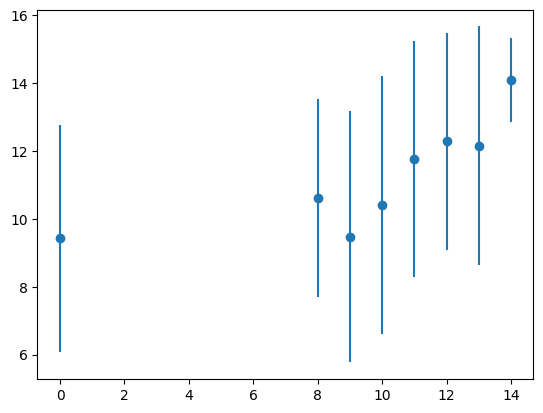

In [8]:
agginfo(alldfs, ["dpobow100_brms25"])

In [13]:
alldfs["dpobow50_rm50"]['scores'][1]

[14.546875, 14.5546875, 14.4140625, 14.3671875]

In [116]:
# Check how well-calibrated RMs are over here
BASE = "../../outputs/calibscos/"
filt = "token"
funct = "bagofwords"
scodirs = listdir(BASE)
alldfs = {}
# go through and load everything in 
for s in scodirs:
    if filt in s:
        alldfs[s] = pd.read_json(BASE+s, lines=True, orient='records')
        # TODO add on the synthetic scoring piece
        print(s)
        alldfs[s]['gold'] = scofile(BASE+s, funct, True)

tokenpredbow25_rm6000
[2.5, 2.75, 2.5, 3.5, 3.75, 2.5, 5.75, 4, 3.5, 2.5, 3.5, 3.25, 2.5, 3.25, 4, 2.5, 3.25, 2.25, 4.5, 3.75, 4, 2.5, 2, 3.5, 2.75, 3.25, 3.75, 3.75, 3.5, 2.75, 2.25, 3.5, 4, 2.5, 2.5, 4.25, 2, 3.25, 3, 3.25, 3, 3.5, 3.75, 2.5, 3.75, 5, 4, 4, 3.75, 2.5, 2.25, 4, 3.5, 3.5, 1.5, 2.75, 3.25, 4.25, 3.5, 3.25, 4, 3.25, 4, 4, 0, 4, 4.75, 2.75, 2.5, 3.25, 3.75, 3, 4.25, 2.75, 1.75, 3.75, 2, 5, 3.25, 3.25, 4.25, 3, 4.5, 3.25, 4.25, 3, 1.75, 3.25, 1.75, 2.75, 3.75, 3, 4, 2, 3.5, 3.25, 2.75, 2.5, 5, 1.75]
3.2425
tokenpredbow50_rm6000
[6.5, 5.75, 4.5, 8.5, 5, 5.75, 4.25, 4.25, 4.75, 5, 5.5, 6, 6, 6, 5.5, 5.5, 4.5, 6.25, 6.5, 5.25, 5.25, 5.5, 5, 5, 5, 4.75, 7, 5.5, 5.75, 6.25, 4.5, 4.5, 5.75, 5.25, 5.75, 5, 5.25, 5.75, 5.75, 5.75, 4, 6.25, 7, 4.5, 5.25, 5.75, 6.25, 5.5, 6.25, 4.75, 6, 4.75, 6.25, 6.5, 4.25, 5, 4.25, 6.5, 5.5, 5, 6.5, 4.75, 7.25, 5.75, 0, 6.25, 6.25, 5.25, 7, 4, 5, 6, 5, 5.75, 5.5, 5.5, 5.5, 4, 5.5, 5.75, 4.75, 5.5, 6, 5, 5.25, 6.5, 3.75, 6, 3.75, 6.5, 6.25, 5.25, 

In [117]:
alldfs.keys()

dict_keys(['tokenpredbow25_rm6000', 'tokenpredbow50_rm6000', 'tokenpredbow100_rm6000', 'tokenpredbow200_rm6000'])

[51.25, 51.5, 52.5, 51.5]
0.0010661646844261222


/u/prasanns/miniconda3/envs/rlhfenv/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


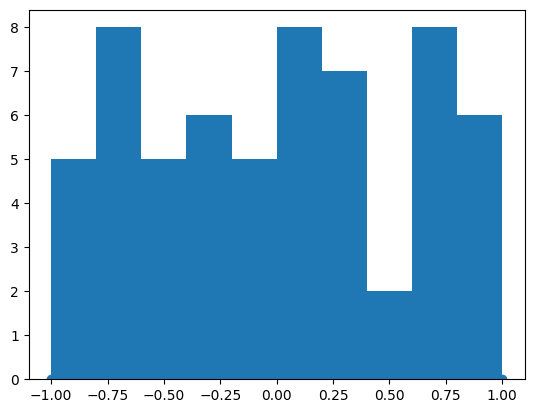

In [118]:
spvals, gpvals = checkdistcorrs(alldfs, ["tokenpredbow200_rm6000"])

In [77]:
tmp = Dataset.load_from_disk("../../data/fixedreversebowdpo/")

In [78]:
tmp = pd.DataFrame(tmp)

In [79]:
tmp.score_j.quantile(0.95)

1.0

In [83]:
max(tmp['score_j'])

3.0

PearsonRResult(statistic=0.003938436759617613, pvalue=0.9233054996812565)

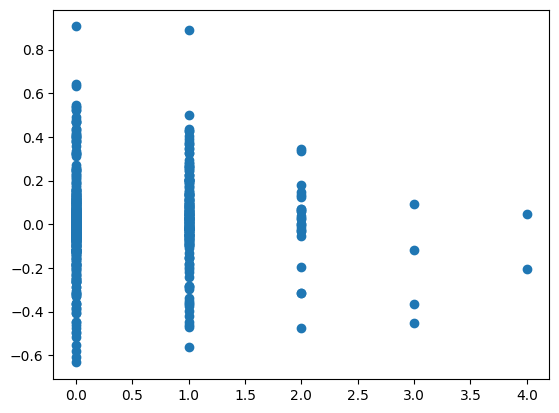

In [40]:
spv = []
gpv = []
for i in range(len(gpvals)):
    spv.extend(spvals[i])
    gpv.extend(gpvals[i])
plt.scatter(gpv, spv)
pearsonr(gpv, spv)

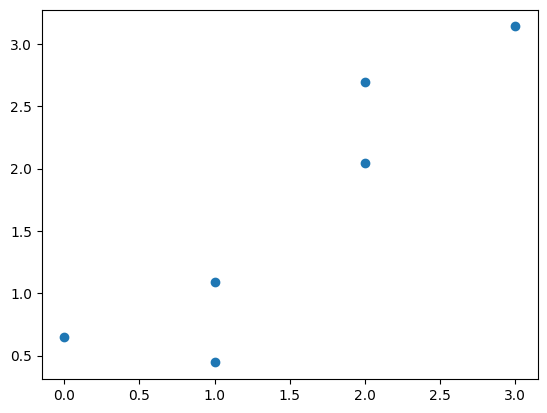

In [32]:
ind = 8
plt.scatter(gpvals[ind], spvals[ind])

In [84]:
import torch

In [87]:
scores = torch.tensor([0,1,2,3])

In [88]:
scores.unsqueeze(1) - scores.unsqueeze(0)

tensor([[ 0, -1, -2, -3],
        [ 1,  0, -1, -2],
        [ 2,  1,  0, -1],
        [ 3,  2,  1,  0]])

In [ ]:
pairwise_diff = scores.unsqueeze(1) - scores.unsqueeze(0)

# Apply absolute value and sigmoid
loss = torch.sigmoid(torch.abs(pairwise_diff))

In [92]:
it = iter([0,1,2,3,4,5])

In [102]:
for i in range(20):
    val = next(it)
    if val is not None:
        print(val)
    else:
        it = iter([0,1,2,3,4,5])

5


StopIteration: 

In [99]:
val = next(it)

In [101]:
val

4